In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import re
import alphashape
import trimesh
%matplotlib notebook

In [2]:
def read_VRML_file(fname):
    coord = []
    normalVector = []
    coordIndex = []

    f = open(fname, "r")
    nodeCount = 0
    while 1 :   # skip initial parameters    
        ln=f.readline().split() #python3
          # termination condition:
        flag = False
        eof = 0
        while ln == []:
            ln=f.readline().split()
            eof += 1
            if eof > 10:
                flag = True
                break

        if flag:
            break

        if (ln !=[]) and (ln[0] == 'point'):
            nodeCount+=1

            print('Reading vertex coordinates.')      
            ln[4] = ln[4][:-1] 
            coord.append(ln[2:5]) #first coordinate
            while 1:
                ln = f.readline().split()
                if len(ln) > 2:
                    ln[2] = ln[2][:-1] #remove comma
                    coord.append(ln[0:3])
                if ln == ['}']:
    #                 list2csv(coord, root+'_coord_'+str(nodeCount)+'.csv')
                    break

            # get normal
            print('Reading normal vectors.')

            f.readline() #normal
            f.readline() #Normal {
            ln = f.readline().split()
            ln[4] = ln[4][:-1] #remove comma
            normalVector.append(ln[2:5])
            while 1:
                ln = f.readline().split()
                if len(ln)>2:
                    if ln[2].endswith(','):
                        ln[2] = ln[2][:-1] 
                    normalVector.append(ln[0:3])
                if ln == ['}']:
    #                 list2csv(normalVector, root+'_normal_'+str(nodeCount)+'.csv')
                    break

            # then get coordIndex
            print('Reading coordinate indices.')

            ln = f.readline().split() #first coordIndex 
            coordIndex.append([ln[2][:-1],ln[3][:-1],ln[4][:-1]])
            coordIndex.append([ln[6][:-1],ln[7][:-1],ln[8][:-1]])
            while 1:
                ln = f.readline().split()
                if len(ln) > 7:
                    coordIndex.append([ln[0][:-1],ln[1][:-1],ln[2][:-1]])
                    coordIndex.append([ln[4][:-1],ln[5][:-1],ln[6][:-1]])
                if len(ln) == 9:
    #                 list2csv(coordIndex, root+'_index_'+str(nodeCount)+'.csv',FMT = '%.0f') 
                    break

            # calculate face normal
    #         print('Calculating face normals.')
    #         if calculateFaceNormal == True:
    #             getFaceNormal(root, nodeCount)
    return coord, normalVector, coordIndex

In [3]:
def normal(triangles):
    # The cross product of two sides is a normal vector
    return np.cross(triangles[:,1] - triangles[:,0], 
                    triangles[:,2] - triangles[:,0], axis=1)

def area(triangles):
    # The norm of the cross product of two sides is twice the area
    return np.linalg.norm(normal(triangles), axis=1) / 2

def sample(triangles, M):
    areas = area(triangles)
    points = []
    for i in range(M):
        xx = np.random.uniform() * sum(areas)
        j = 0
        s = 0
        while s < xx:
            s += areas[j]
            j += 1
        triangle = triangles[j-1]
        s = np.random.uniform()
        t = np.random.uniform()
        if s + t > 1:
            s = 1 - s
            t = 1 - t
        p = (triangle[2] - triangle[0]) * s + (triangle[2] - triangle[0]) * t  + triangle[0]
        points.append(p)
    points = np.array(points)
    return points

In [4]:
def trn_rm0(triangles, M, random_seed=None):
    if random_seed is not None: np.random.seed(seed=random_seed)

    rm0 = sample(triangles, M)
    return rm0

def trn_iterate(triangles, rm0,
  n_save=10,
  e0=0.3,
  ef=0.05,
  l0=None,
  lf=0.5,
  tf=None,
  do_log=True,
  log_n=10,
):
    M = rm0.shape[0]
    d = rm0.shape[1]
    if l0 is None: 0.067*M
    if tf is None: tf=200*M
    rms = np.empty((n_save+1,M,d))
    rms[0] = rm0
    rs = np.empty((tf+1,d))
    ts_save = np.empty((n_save+1)).astype(np.int32)

    
    rm = rm0
    save_idx=0

    for t in range(tf):
#         print(t)
#         print(tf)
        r = sample(triangles, 1)[0]
#         print(r)
        rs[t]=r
        dist2 = ((r - rm)**2).sum(1) # usually sum over xyz. just need relative rank in one time step, so can use dist2 vs dist
        order = dist2.argsort()
        rank = order.argsort().reshape(-1,1)
        l = l0*(lf/l0)**(t/tf)
        e = e0*(ef/e0)**(t/tf)
        rm = rm + e*np.exp(-rank/l)*(r-rm)
        if do_log and ((t % (tf//n_save) == 0) or (t == tf-1)): 
            rms[save_idx] = rm
            ts_save[save_idx] = t
            save_idx+=1
    return rms,rs,ts_save

def trn_wrapper(triangles,
                M=1000,
                random_seed=None,
                n_save=10,
                e0=0.3,
                ef=0.05,
                l0_factor=0.005,
                lf=0.5,
                tf_factor=8, # typically M*8
                do_log=True,
                log_n=10
                ):
    triangles = triangles.copy()
    rm0 = trn_rm0(triangles, M=M, random_seed=random_seed)
    rms,rs,ts_save = trn_iterate(triangles, rm0, n_save=n_save,e0=e0,ef=ef,l0=M*l0_factor,lf=lf,tf=M*tf_factor,do_log=do_log,log_n=log_n)
    return rm0,rms,rs,ts_save

In [5]:
def compute_curvature(alpha_shape, r, dist):
    n = alpha_shape.vertices.shape[0]
    curvature_vertices = trimesh.curvature.discrete_gaussian_curvature_measure(alpha_shape, alpha_shape.vertices, [0]*n)
    
    curvature_points = []
    curvature = []
    for v in alpha_shape.vertices:
        curvature_points.append(v)

    for c in curvature_vertices:
        curvature.append(c)

    for e in alpha_shape.edges:
        v1 = alpha_shape.vertices[e[0]]
        v2 = alpha_shape.vertices[e[1]]
        c1 = curvature_vertices[e[0]]
        c2 = curvature_vertices[e[1]]
        for d in range(1, dist):
            curvature_points.append((d*v1 + (dist-d)*v2)/dist)
            curvature.append((d*c1 + (dist-d)*c2)/dist)

    for f in alpha_shape.faces:
        v1 = alpha_shape.vertices[f[0]]
        v2 = alpha_shape.vertices[f[1]]
        v3 = alpha_shape.vertices[f[2]]
        c1 = curvature_vertices[f[0]]
        c2 = curvature_vertices[f[1]]
        c3 = curvature_vertices[f[2]]
        for d1 in range(1, dist):
            for d2 in range(1, dist-d1):
                d3 = dist - d1 -d2
                curvature_points.append((d1*v1 + d2*v2 + d3*v3)/dist)
                curvature.append((d1*c1 + d2*c2 + d3*c3)/dist)
    curvature_points = np.array(curvature_points)
    curvature = np.array(curvature)
    
    if r== 0:
        return curvature, curvature_points
    
    curvature = trimesh.curvature.discrete_gaussian_curvature_measure(alpha_shape, curvature_points, [r]*curvature_points.shape[0])
    return curvature, curvature_points

In [6]:
def analyze(fname, num_points=3000, radius_curvature=0.2, alpha=3):
    coord, normalVector, coordIndex = read_VRML_file(fname)
    triangles = []
    for t in coordIndex:
        a = coord[int(t[0])]
        b = coord[int(t[1])]
        c = coord[int(t[2])]
        triangles.append([
            [float(a[0]), float(a[1]), float(a[2])],
            [float(b[0]), float(b[1]), float(b[2])],
            [float(c[0]), float(c[1]), float(c[2])]
        ])
    triangles = np.array(triangles)
    # print(triangles)
    print('Generating point cloud.')
    M = num_points
    l0_factor = 0.005 # larger tightens things up (far apart areas too much to much, pulls together). smaller spreads things out
    lf = 0.5
    tf_factor = 8
    e0 = 0.3
    ef = 0.05
    rm0,rms,rs,ts_save = trn_wrapper(triangles,M=M,n_save=10,e0=e0,ef=ef,l0_factor=l0_factor,lf=lf,tf_factor=tf_factor,do_log=True,log_n=10)

#     print("Point cloud generated.")

    print('Generating alpha shape.')
    xs = []
    ys = []
    zs = []
    for i in range(M):
        xs.append(rms[10][i][0])
        ys.append(rms[10][i][1])
        zs.append(rms[10][i][2])

    ran = max(max(xs) - min(xs), max(ys) - min(ys), max(zs) - min(zs))/2
    mid_x = (max(xs)+min(xs)) * 0.5
    mid_y = (max(ys)+min(ys)) * 0.5
    mid_z = (max(zs)+min(zs)) * 0.5

    points_3d = []
    for i in range(len(xs)):
        points_3d.append((xs[i], ys[i], zs[i]))

    alpha_shape = alphashape.alphashape(points_3d, alpha)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces)

    ax.set_xlim(mid_x - ran, mid_x + ran)
    ax.set_ylim(mid_y - ran, mid_y + ran)
    ax.set_zlim(mid_z - ran, mid_z + ran)
    plt.title('Alpha Shape')
    plt.show()
    
    print('Computing curvature.')
    curvature, curvature_points = compute_curvature(alpha_shape, radius_curvature, 3)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces)

    x = []
    y = []
    z = []
#     print(curvature_points)
#     print(curvature_points.shape)
    for p in curvature_points:
        x.append(p[0])
        y.append(p[1])
        z.append(p[2])


    points = ax.scatter(x, y, z, c=curvature, s=1, alpha=0.5, cmap="plasma")

    plt.colorbar(points)
    ax.set_xlim(mid_x - ran, mid_x + ran)
    ax.set_ylim(mid_y - ran, mid_y + ran)
    ax.set_zlim(mid_z - ran, mid_z + ran)
    plt.title('Gaussian curvature')
    plt.show()

Reading vertex coordinates.
Reading normal vectors.
Reading coordinate indices.
Generating point cloud.
Generating alpha shape.


<IPython.core.display.Javascript object>


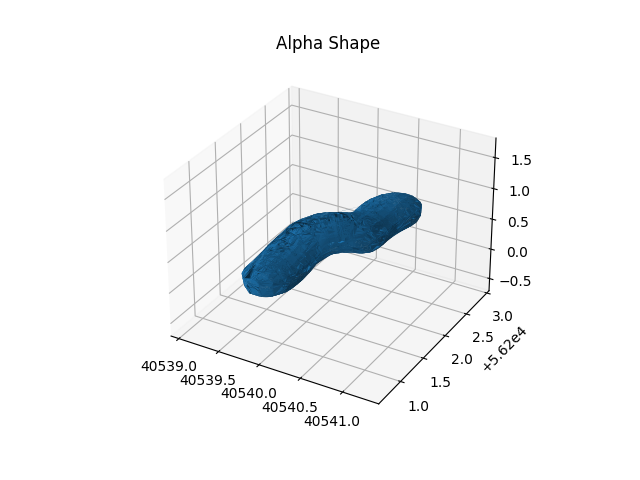

Computing curvature.


<IPython.core.display.Javascript object>


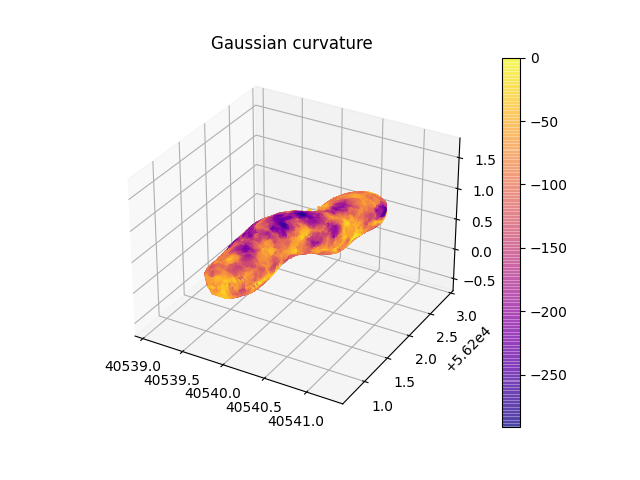

In [7]:
analyze('vrml', num_points=5000, radius_curvature=0.1, alpha=4)

Reading vertex coordinates.
Reading normal vectors.
Reading coordinate indices.
Generating point cloud.
Generating alpha shape.


<IPython.core.display.Javascript object>


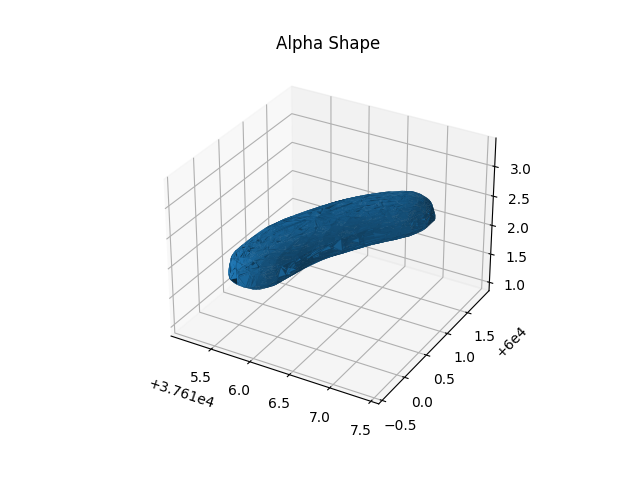

Computing curvature.


<IPython.core.display.Javascript object>


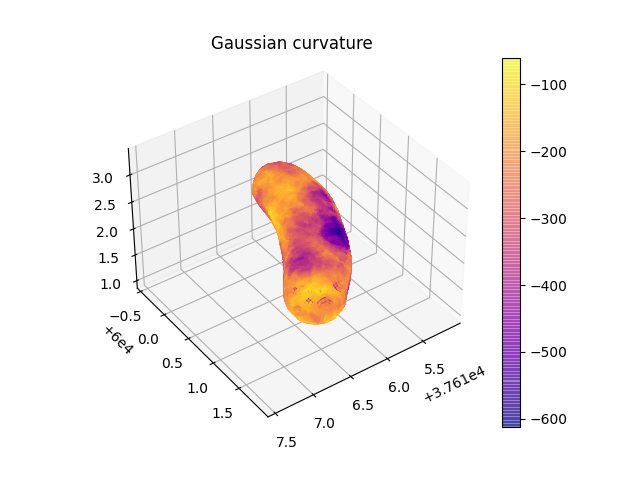

In [8]:
analyze("E324Q/∆pgp2E324Q.wrl", num_points=5000, radius_curvature=0.2, alpha=2)

Reading vertex coordinates.
Reading normal vectors.
Reading coordinate indices.
Generating point cloud.
Generating alpha shape.


<IPython.core.display.Javascript object>


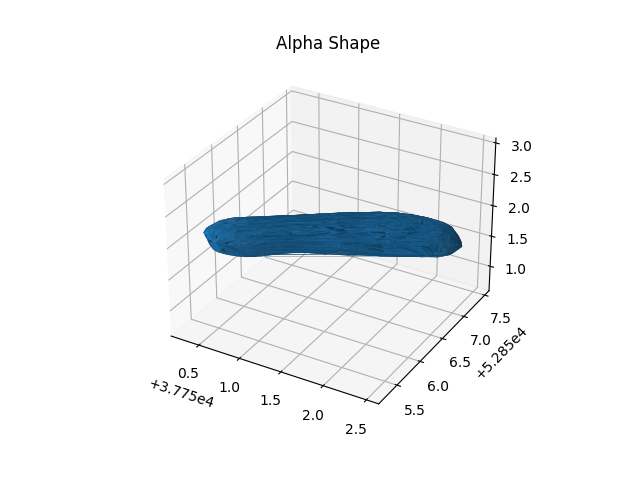

Computing curvature.


<IPython.core.display.Javascript object>


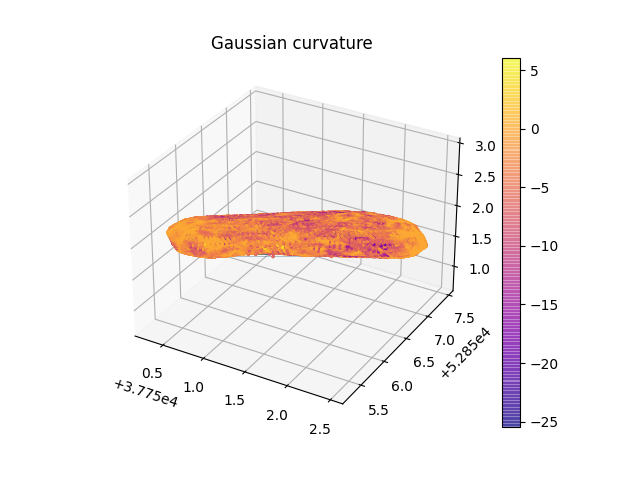

In [9]:
analyze("K257A/∆pgp2K257A.wrl", num_points=5000, radius_curvature=0, alpha=1)